## Time Series Analysis: Understanding generic drug price changes in past 2 years

### For Time Series Analysis both NADAF and MDDB datasets are utilized. 
   
#### Time Series dataset is based on these columns from NADAF dataset:
   - Effective_Date: Date in MM/DD/YYYY format
   - NADAC_Per_Unit: Invoice price of a given drug identified by NDC. 

#### Time Series Analyzing Functions are created to:
   - Convert NADAF dataframe to time series dataframe based on GPPC or GPID grouping
   - Plot Auto Correlation Analysis
   - Plot Seasonality Decomposition 
   - Modeling and forcasting Time Series is done using ARIMA(AutoRegressive Integrated Moving Average) model
       - Augmented Dickey Fuller test is conducted to see whether the given series is stationary
    
               
#### Time Series Analysis is done on two generic drug groups:
   1. Oxycodine (Pain Medication), GPID gouping is identified for Time Series analysis
   2. Thyroid Tab (Thyroid Medication), GPPC grouping is identified for Time Series analysis
 

In [185]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,matthews_corrcoef

from warnings import filterwarnings
filterwarnings('ignore')
import missingno as msno
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

In [2]:
nadac_df = pd.read_csv('data/nadac-national-average-drug-acquisition-cost-08-03-2022.csv')
nadac_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776578 entries, 0 to 776577
Data columns (total 12 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   NDC Description                            776578 non-null  object 
 1   NDC                                        776578 non-null  int64  
 2   NADAC_Per_Unit                             776578 non-null  float64
 3   Effective_Date                             776578 non-null  object 
 4   Pricing_Unit                               776578 non-null  object 
 5   Pharmacy_Type_Indicator                    776578 non-null  object 
 6   OTC                                        776578 non-null  object 
 7   Explanation_Code                           776578 non-null  object 
 8   Classification_for_Rate_Setting            776578 non-null  object 
 9   Corresponding_Generic_Drug_NADAC_Per_Unit  19515 non-null   float64
 10  Correspo

### NADAC Data Dictionary
- **NDC Description**: National Drug Code Description 
    -             (Identifieds the drug name, strength and dosage form of the drug product)
- **NDC**            : National Drug Code
    -             (11-digit code maintained by the FDA that includes labeler code(first 4-5 digits), product code  & package code (last 5 to 6 digits)
- **NADAC Per Unit** : The National Average Drug Aquisition Cost per Unit
- **Effective Date** : The effective date of the NADAC Per Unit Cost
- **Pricing Unit**   : Indicates the pricing unit for the associated NDC ('ML', 'GM', or 'EA')
- **Pharmacy Type Indicator**: Where this data is collected C (Chain) or I (Independent) pharmacies
- **OTC**: Indicates whether this drug is OVer The Counter product or not (Y or N)  
- **Explanation Code**: Codes that pertain to how the NADAC was calculated, ( Codes 1 to 5) 
- **Classification for Rate Settings**: Indicates whether product is Brand(B), Generic (G), ANDA, B-ANDA, B-BIO
    - ANDA (approved under and Abbreviated New Drug Application) 
    - B-BIO (Brand Bio Similar)
- **Corresponding Generic Drug NADAC Per Unit**: The NADAC for corresponding generic product (if NDC is a Brand)
- **Corresponding Generic Drug Effective Date**: The effective date when NADAC is assigned to generic drug 

In [196]:
mddb_df             = pd.read_csv('data/mddb.csv') 
mddb_df['AWP']      = mddb_df['AWP'] / mddb_df['TOTPCKQTY']
mddb_df['AWPTOTAL'] = mddb_df['AWP'] * mddb_df['TOTPCKQTY']
mddb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285388 entries, 0 to 285387
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   NDC           285388 non-null  int64  
 1   GENERIC_NAME  285388 non-null  object 
 2   GPID          285388 non-null  object 
 3   GPPC          285388 non-null  object 
 4   STRENGTHDS    285388 non-null  float64
 5   STRENGTHUM    167594 non-null  object 
 6   SIZE          285388 non-null  float64
 7   FORM          285388 non-null  object 
 8   SIZEUOM       285388 non-null  object 
 9   PACKQTY       285388 non-null  int64  
 10  TOTPCKQTY     285388 non-null  float64
 11  WAC           285388 non-null  float64
 12  WACTOTAL      285388 non-null  float64
 13  AWP           285388 non-null  float64
 14  AWPTOTAL      285388 non-null  float64
dtypes: float64(7), int64(2), object(6)
memory usage: 32.7+ MB


### MDDB Data Dictionary
- This dataset contains additional information which gives us drug classification, Wholesale Aquisition Cost (WAC) and Average Wholesale Price (AWP) 

#### This is a shorter version of  Master Drug Data Base (MDDB)
- **NDC**            : National Drug Code
    -             (11-digit code maintained by the FDA that includes labeler code(first 4-5 digits), product code  & package code (last 5 to 6 digits)
- **GENERIC_NAME** : Identifieds the drug name, strength and dosage form of the drug product
- **GPID** : Generic Product Identifier 
    -      14 Character GPID consists of heirarchy of Drug Group (first 2 chars), Drug Class (first 4 chars), Drug Subclass (first 6 chars), Drug Name(first 8 chars), Drug Name Ext (first 10 chars), Dosage Form (first 12 chars) & Strength (total 14 chars) 
- **GPPC** : Generic Product Packaging Code
    - 8 character code, The first five characters are random and last three represent Package Description, Package Size, Package Size unit of Measure, Package Quantity and Unit Dose / Unit of Use Packaging Code  
- **STRENGTHDS**: Digits representing strength of the Chemical Formula
- **STRENGTHUM**: Unit Measures of the Chemical Formula (ML, MG, etc)
- **SIZE**: Number that represnts the size interms of capsules or ML of liquid
- **FORM**: Form in which drug is composed (Tablets, Capsules, Liquid etc) 
- **SIZEUOM**: Unit of Measure of Size mentioned above
- **PACKQTY**: Number of items in the same package
- **TOTPCKQTY**: SIZE x PACKQTY
- **WAC**: Wholesaler Acquisition Cost (Price payed by Wholesaler/Distributor to Manufacturer)
- **WACTOTAL**: WAC x TOTPCKQTY
- **AWP**: Average Wholesale Price (Average Price Payed by Retailer to Wholesaler) 
- **AWPTOTAL**: AWP x TOTPCKQTY

In [3]:
nadac_df['Effective_Date'].unique()

array(['12/22/2021', '12/15/2021', '11/17/2021', '04/21/2021',
       '10/20/2021', '04/01/2021', '01/19/2022', '01/15/2022',
       '08/18/2021', '02/02/2022', '01/12/2022', '05/19/2021',
       '07/21/2021', '08/04/2021', '09/22/2021', '10/02/2021',
       '01/01/2022', '06/23/2021', '01/26/2022', '04/07/2021',
       '02/17/2021', '03/17/2021', '01/14/2022', '01/03/2022',
       '01/10/2022', '04/02/2021', '10/01/2021', '12/30/2021',
       '11/03/2021', '01/06/2022', '12/29/2021', '02/01/2022',
       '10/27/2021', '07/14/2021', '03/03/2021', '01/05/2022',
       '10/13/2021', '02/09/2022', '11/10/2021', '10/30/2021',
       '07/01/2021', '01/11/2022', '12/17/2021', '06/16/2021',
       '07/28/2021', '09/15/2021', '08/01/2021', '09/01/2021',
       '01/20/2022', '09/29/2021', '08/11/2021', '06/24/2021',
       '06/01/2021', '10/14/2021', '10/06/2021', '02/24/2021',
       '05/26/2021', '01/17/2022', '12/09/2021', '01/25/2022',
       '10/08/2021', '10/19/2021', '09/08/2021', '08/12

In [207]:
nadac_df[['Effective_Month','Effective_Day','Effective_Year']] = nadac_df['Effective_Date'].str.split("/",expand=True)
nadac_df.head()

,NDC Description,NDC,NADAC_Per_Unit,Effective_Date,Pricing_Unit,Pharmacy_Type_Indicator,OTC,Explanation_Code,Classification_for_Rate_Setting,Corresponding_Generic_Drug_NADAC_Per_Unit,Corresponding_Generic_Drug_Effective_Date,As of Date,Effective_Month,Effective_Day,Effective_Year
0,12HR NASAL DECONGEST ER 120 MG,24385005452,0.29366,12/22/2021,EA,C/I,Y,1,G,NaN,NaN,01/05/2022,12,22,2021
1,12HR NASAL DECONGEST ER 120 MG,70000047501,0.29366,12/22/2021,EA,C/I,Y,1,G,NaN,NaN,01/05/2022,12,22,2021
2,24H NASAL ALLERGY 55 MCG SPRAY,46122038576,0.78092,12/22/2021,ML,C/I,Y,"1, 5",G,NaN,NaN,01/05/2022,12,22,2021
3,24HR ALLERGY(LEVOCETIRZN) 5 MG,70000036201,0.19147,12/22/2021,EA,C/I,Y,1,G,NaN,NaN,01/05/2022,12,22,2021
4,24HR ALLERGY(LEVOCETIRZN) 5 MG,70000036202,0.19147,12/22/2021,EA,C/I,Y,1,G,NaN,NaN,01/05/2022,12,22,2021


### Functions for Time Series Analysis

In [195]:
def get_timeseries_df_by_group(group_name, group_id):
    ''' This function takes group name (GPID or GPPC) and its value as inputs.
        Queries MDDB based on the inputed group_name and value and with the query results:
            * It retrieves all the similar items from NADAF dataframe 
            * Converts the NADAF subset into timeseries and returns.
    '''
    if(group_name == 'GPID'):
        df   = mddb_df.query("GPID == @group_id")
    else:
        df   = mddb_df.query("GPPC == @group_id")
    
    if(df.empty):
        return None
    
    generic_name  = df['GENERIC_NAME'].iloc[0]
    print('*****************************************************************************************')
    print('TimeSeries Analysis is done on', group_name,  group_id, generic_name)
    print('*****************************************************************************************')
    gpid_ndcs     = df['NDC'].values
    to_predict_df = nadac_df[nadac_df['NDC'].isin(gpid_ndcs)]
    timeseries_df = to_predict_df[['NADAC_Per_Unit','Effective_Date']]
    timeseries_df['Effective_Date'] = pd.to_datetime(timeseries_df['Effective_Date'],format='%m/%d/%Y')
    timeseries_df = timeseries_df.set_index(pd.DatetimeIndex(timeseries_df['Effective_Date'])).drop(columns=['Effective_Date'])
    timeseries_df.sort_index(inplace=True)
    return timeseries_df


def plot_auto_correlation(timeseries_df):
    ''' This function takes a timeseries dataframe and plots Auto Correlation ''' 
    autocorrelation_plot(timeseries_df)
    plt.show();
    
    y_hist, y_future = train_test_split(timeseries_df, shuffle=False)
    fig, ax = plt.subplots(1, 2, figsize = (16, 5))
    plot_acf(y_hist, ax = ax[0]);
    ax[0].grid()
    plot_pacf(y_hist, ax = ax[1], method = 'ywm');
    ax[1].grid()
    plt.show();
    

def plot_seasonal_decomposition(timeseries_df):
    ''' This function takes a timeseries dataframe and plots Seasonal Decomposition '''  
    decomposed = seasonal_decompose(timeseries_df['NADAC_Per_Unit'],period = 2)
    plt.rcParams['figure.figsize'] = (10, 8)
    x = decomposed.plot()
    plt.plot(decomposed.resid)
    plt.grid();


def model_forecast_timeseries(timeseries_df, ar_p, d, ma_q):
    ''' This function takes a timeseries dataframe and Arima's AR(p) value and Arima's MA(q) value as inputs
        Then does AD Fuller test to check whether given siries is stationary, if not it returns
        If ADFuller test is satisfied, it create a ARIMA model, predicts and forecasts
        Also plots the the Predicted, Actual & Forecasted values and prints MSE
    '''  
    adfuller_test_result = adfuller(timeseries_df['NADAC_Per_Unit'])[0]
    if(adfuller_test_result > 0.05):
        print('Adfuller test failed with result greater than 0.05:', adfuller_test_result)
        return
    
    y_hist, y_future = train_test_split(timeseries_df, shuffle=False)
    arma             = ARIMA(y_hist['NADAC_Per_Unit'], order = (ar_p, d, ma_q)).fit()
    print(arma.summary())
    hist_preds       = arma.predict()
    future_preds     = arma.forecast(steps = len(y_future)).set_axis(y_future.index)

    avg_hist_price   = np.mean(hist_preds)
    avg_actual_historical_price = np.mean(y_hist['NADAC_Per_Unit'])
    avg_future_price = np.mean(future_preds)
    avg_actual_future_price = np.mean(y_future['NADAC_Per_Unit'])
    
    print()
    print('Historical average predicted invoice price: ', round(avg_hist_price,2))
    print('Historical average actual invoice price: ', round(avg_actual_historical_price,2))
    print('Future average invoice price: ', round(avg_future_price,2))
    print('Actual Future average invoice price: ', round(avg_actual_future_price,2))
    plt.figure(figsize = (12, 4))
    plt.plot(hist_preds, label = 'Predicted')
    plt.plot(y_hist, label = 'Actual')
    plt.plot(future_preds, label = 'Future')
    plt.plot(y_future, label ='Actual Future')
    plt.legend()
    plt.grid()
    plt.title('Result of ARMA Model');
    plt.show();

    mse = mean_squared_error(y_future, future_preds )
    mape = mean_absolute_percentage_error(y_future, future_preds )
    print('Mean Squared Error', mse)
    print('Mean Absolute Percentage Error', mape)


### What is the difference between GPID and GPPC grouping?
   - GPPC is a subset of GPID group ( A group of NDCs )
   - Both GPID and GPPC represent the same Generic drug, it's form and strength.
   - The only difference is GPPC contians package size.
   - A GPID can contain many NDCs with different GPPCs.

#### 1) Oxycodine (Pain Medication), GPID gouping is identified for Time Series analysis

*****************************************************************************************
TimeSeries Analysis is done on GPID 65100075102005 Oxycodone HCl Soln 5 MG/5ML
*****************************************************************************************


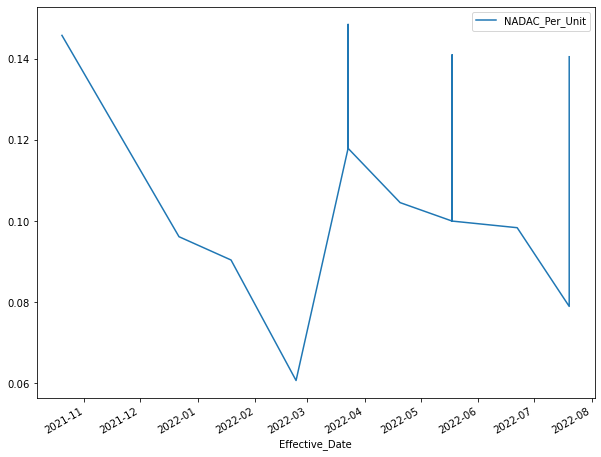

In [199]:
gpid = mddb_df.query("GENERIC_NAME.str.contains('Oxycodone') ")['GPID'].iloc[4]
gpid_timeseries_df = get_timeseries_df_by_group('GPID',gpid)
gpid_timeseries_df.plot()
plt.show();

                NADAC_Per_Unit
Effective_Date                
2021-10-20             0.14575
2021-10-20             0.14575
2021-10-20             0.14575
2021-10-20             0.14575
2021-10-20             0.14575
...                        ...
2022-07-20             0.07897
2022-07-20             0.07897
2022-07-20             0.14049
2022-07-20             0.07897
2022-07-20             0.14049

[279 rows x 1 columns]


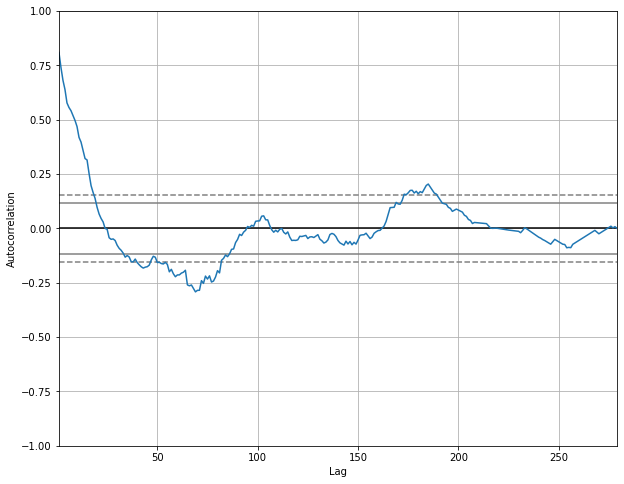

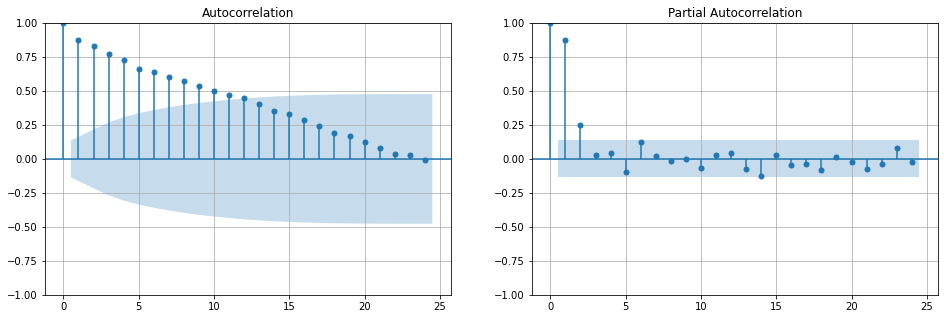

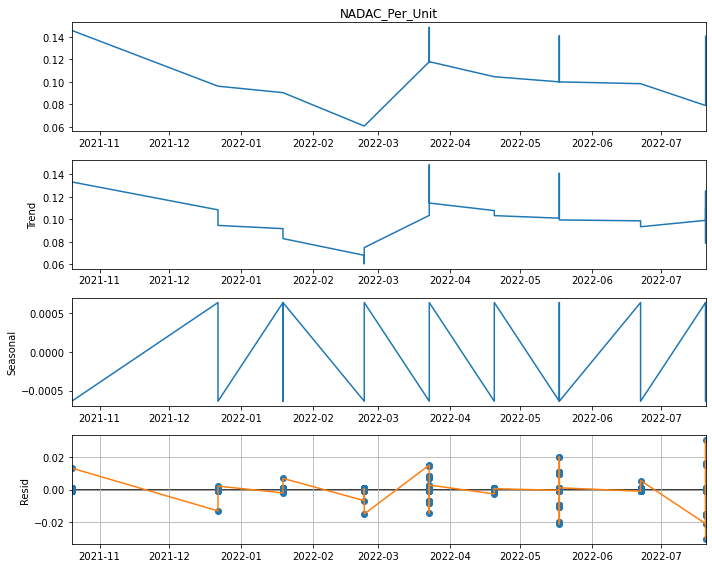

In [211]:
if(gpid_timeseries_df is not None):
    print(gpid_timeseries_df)
    plot_auto_correlation(gpid_timeseries_df)
    plot_seasonal_decomposition(gpid_timeseries_df)

#### Observations:
   - Based on Partial Correlation plot, AR(p) value is 2
   - We are not differencing the observations, so left d value as 0
   - Based on Auto Correlation plot, MA(q) value is 12

                               SARIMAX Results                                
Dep. Variable:         NADAC_Per_Unit   No. Observations:                  209
Model:                ARIMA(2, 0, 12)   Log Likelihood                 626.797
Date:                Sun, 11 Sep 2022   AIC                          -1221.594
Time:                        22:03:41   BIC                          -1168.116
Sample:                             0   HQIC                         -1199.973
                                - 209                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1089      0.012      9.323      0.000       0.086       0.132
ar.L1          0.5466      0.429      1.276      0.202      -0.293       1.387
ar.L2          0.3477      0.434      0.801      0.4

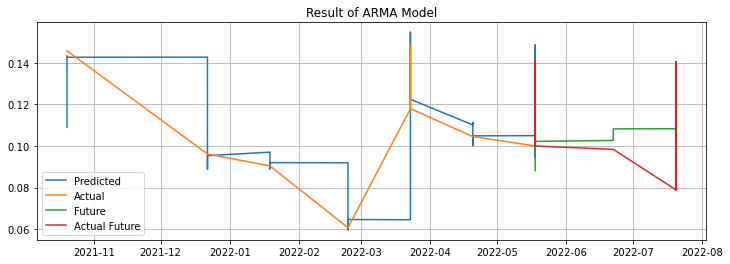

Mean Squared Error 0.0004266289208173572
Mean Absolute Percentage Error 0.18045980855627822


In [192]:
model_forecast_timeseries(gpid_timeseries_df, 2, 0, 12)

#### Observations: 
   - GPID 65100075102005 Oxycodone HCl Soln 5 MG/5ML Time Series (206 observations) is Stationary
   - Model forecast that average future price of Oxycodone HCl Soln 5 MG/5ML will be $0.1
   - Mean Squared Error for our model is low: 0.00032116869687319385
   - Mean Absolute Percentage Error is 18% means model is 82% accurate

#### 2) Thyroid Tab  (Thyroid Medication), GPPC grouping is identified for Time Series analysis

*****************************************************************************************
TimeSeries Analysis is done on GPPC 00959003 Thyroid Tab 15 MG (1/4 Grain)
*****************************************************************************************


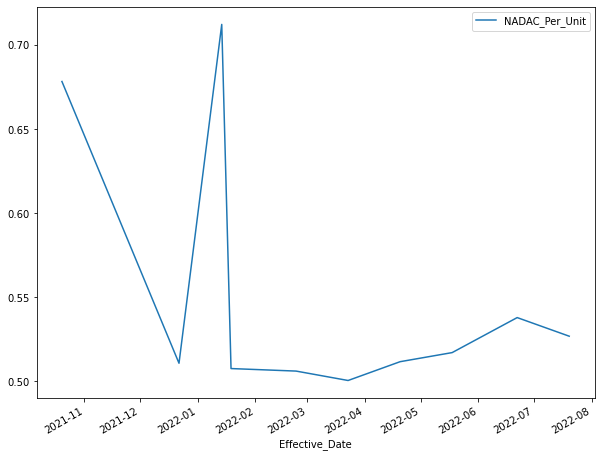

In [206]:
gppc = mddb_df.query("GENERIC_NAME.str.contains('Thyroid') ")['GPPC'].iloc[0]
if gppc is not None:
    gppc_timeseries_df = get_timeseries_df_by_group('GPPC',gppc)
    if(gppc_timeseries_df is not None or not gppc_timeseries_df.empty):
        gppc_timeseries_df.plot()
        plt.show();

                NADAC_Per_Unit
Effective_Date                
2021-10-20             0.67821
2021-10-20             0.67821
2021-10-20             0.67821
2021-10-20             0.67821
2021-12-22             0.51084
...                        ...
2022-06-22             0.53796
2022-06-22             0.53796
2022-07-20             0.52690
2022-07-20             0.52690
2022-07-20             0.52690

[62 rows x 1 columns]


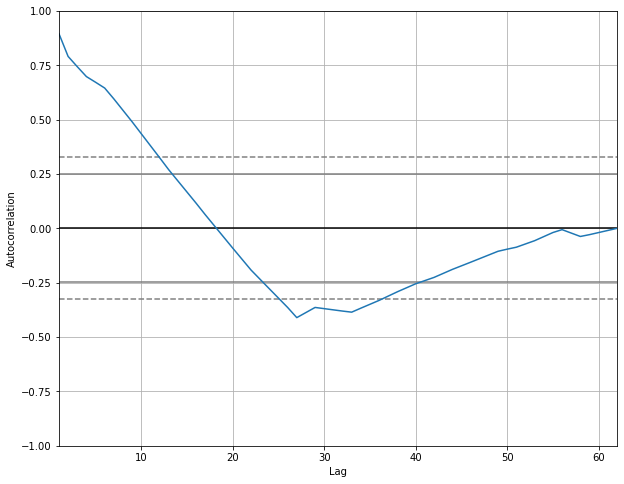

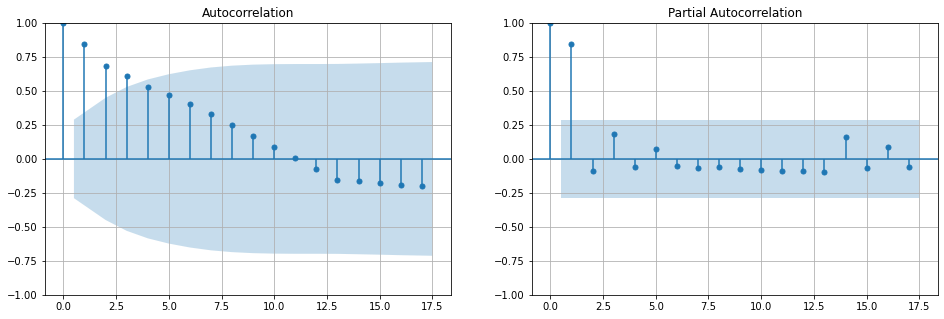

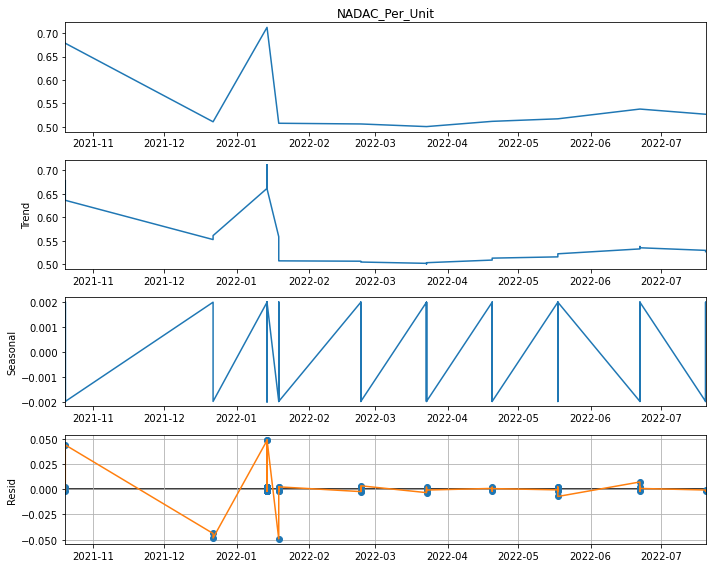

In [209]:
if(gppc_timeseries_df is not None or not gppc_timeseries_df.empty):
    print(gppc_timeseries_df)
    plot_auto_correlation(gppc_timeseries_df)
    plot_seasonal_decomposition(gppc_timeseries_df)

#### Observations:
   - Based on Partial Correlation plot, AR(p) value is 2
   - We are not differencing the observations, so left d value as 0
   - Based on Auto Correlation plot, MA(q) value is 4

                               SARIMAX Results                                
Dep. Variable:         NADAC_Per_Unit   No. Observations:                   46
Model:                 ARIMA(2, 0, 4)   Log Likelihood                  75.526
Date:                Sun, 11 Sep 2022   AIC                           -135.053
Time:                        22:05:07   BIC                           -120.424
Sample:                             0   HQIC                          -129.573
                                 - 46                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6245      0.131      4.752      0.000       0.367       0.882
ar.L1          0.3519     24.184      0.015      0.988     -47.048      47.752
ar.L2          0.5173     22.165      0.023      0.9

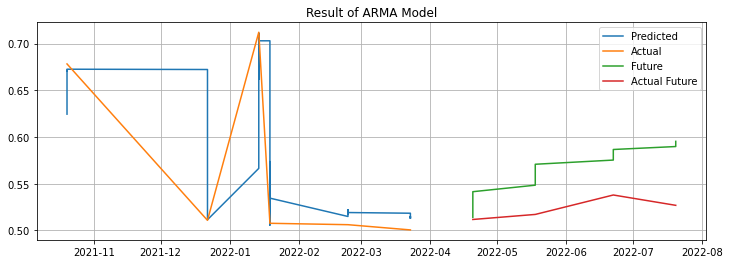

Mean Squared Error 0.00197842293869437
Mean Absolute Percentage Error 0.07782678682322364


In [194]:
model_forecast_timeseries(gppc_timeseries_df, 2, 0, 4)

#### Observation: 
 - GPID 65100075102005 Oxycodone HCl Soln 5 MG/5ML Time Series (206 observations) is Stationary
 - Model forecast that average future price of Oxycodone HCl Soln 5 MG/5ML will be $0.52
    - 4 cents lower than actual future average value
 - Mean Squared Error for our model is low: 0.00197842293869437
 - Mean Absolute Percentage Error is 7.7% means model is 92% accurate

## Conclusion: 
  - The time series analyzing functions given in this notebook will be helpful for both wholesaler & retailer in terms of forcasting the the genetic drug prices by GPID or GPPC groups.
  * Next steps
       - Here both chosen Time series are stationary, functions can be modified to accomidate non-stationary time series 
       - Split the Effective_Date column into Year, Month and Day columns, so that Time Series analysis can be done on a granular level. 
       - LSTM (Long Short-Term Memory) should also be explored on these Time Series datasets.  
    